# Augmented Tool Catalogue Exploration

This notebook explores the BFCL v4 augmented tool catalogue. It compares original
tool descriptions to augmented ones and summarizes several usage statistics.


In [10]:
from pathlib import Path
import json
import random
import textwrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def find_repo_root(start: Path) -> Path:
    for parent in [start] + list(start.parents):
        if (parent / 'berkeley-function-call-leaderboard').exists():
            return parent
    return start

# Change this path to switch catalogues
REPO_ROOT = find_repo_root(Path.cwd())
DATA_PATH = REPO_ROOT / 'berkeley-function-call-leaderboard/bfcl_eval/data/internal/bfcl_v4_tool_catalogue_augmented.jsonl'
if not DATA_PATH.exists():
    raise FileNotFoundError(f'Catalogue not found: {DATA_PATH}')

df = pd.read_json(str(DATA_PATH), lines=True)
df.head()


,tool_name,orig_descriptions,parameters_variants,source_files,task_types,num_occurrences,num_conversations,num_as_ground_truth,aug_description,_rewrite_meta
0,AbstractJarAgent.runJarAgent,[{'description': 'Runs the jar agent with the ...,"[{'parameters': {'type': 'dict', 'properties':...",[simple_java],[single_turn],1,1,1,Use this tool when you need to start and attac...,"{'rewriter_model': 'gpt-5.1-responses', 'rewri..."
1,AbstractTransportSearchableSnapshotsAction.sha...,[{'description': 'Executes a shard-level opera...,"[{'parameters': {'type': 'dict', 'properties':...",[simple_java],[single_turn],1,1,1,Executes a shard-level operation specifically ...,"{'rewriter_model': 'gpt-5.1-responses', 'rewri..."
2,AclApi.add_mapping,[{'description': 'Adds an Access Control List ...,"[{'parameters': {'type': 'dict', 'required': [...",[live_multiple],[single_turn],1,1,1,Use this tool to create a new Access Control L...,"{'rewriter_model': 'gpt-5.1-responses', 'rewri..."
3,Alarm_1_AddAlarm,[{'description': 'Sets a new alarm with specif...,"[{'parameters': {'type': 'dict', 'required': [...",[live_multiple],[single_turn],60,60,6,Use this tool to create a new alarm for a spec...,"{'rewriter_model': 'gpt-5.1-responses', 'rewri..."
4,Alarm_1_GetAlarms,[{'description': 'Retrieve a list of all alarm...,"[{'parameters': {'type': 'dict', 'properties':...",[live_multiple],[single_turn],60,60,5,Use this tool when you need to retrieve all al...,"{'rewriter_model': 'gpt-5.1-responses', 'rewri..."


In [22]:
unique_source_files = df['source_files'].explode().unique()
print(unique_source_files)

['simple_java' 'live_multiple' 'multiple' 'parallel_multiple'
 'simple_javascript' 'live_parallel_multiple' 'live_simple'
 'multi_turn_base' 'multi_turn_long_context' 'multi_turn_miss_func'
 'multi_turn_miss_param' 'memory' 'parallel' 'simple_python' 'web_search'
 'live_parallel']


In [11]:
def join_orig_descs(orig_list):
    if not isinstance(orig_list, list):
        return ''
    parts = []
    for item in orig_list:
        if isinstance(item, dict):
            desc = item.get('description')
            if desc:
                parts.append(desc.strip())
    return ' '.join(parts)

df['orig_desc'] = df['orig_descriptions'].apply(join_orig_descs)
df['aug_desc_len_chars'] = df['aug_description'].fillna('').str.len()
df['aug_desc_len_words'] = df['aug_description'].fillna('').str.split().str.len()
df['orig_desc_len_chars'] = df['orig_desc'].fillna('').str.len()
df['orig_desc_len_words'] = df['orig_desc'].fillna('').str.split().str.len()

df[['tool_name', 'orig_desc_len_chars', 'aug_desc_len_chars']].head()


,tool_name,orig_desc_len_chars,aug_desc_len_chars
0,AbstractJarAgent.runJarAgent,231,943
1,AbstractTransportSearchableSnapshotsAction.sha...,162,981
2,AclApi.add_mapping,107,928
3,Alarm_1_AddAlarm,286,785
4,Alarm_1_GetAlarms,394,790


## Random row: original vs augmented description


In [14]:
row = df.sample(1, random_state=42).iloc[0]
print('Tool:', row['tool_name'])
print('\nOriginal description(s):')
orig_list = row.get('orig_descriptions', [])
if isinstance(orig_list, list) and orig_list:
    for idx, item in enumerate(orig_list, 1):
        desc = item.get('description', '') if isinstance(item, dict) else ''
        src = item.get('source_files', '') if isinstance(item, dict) else ''
        label = f'[{idx}]'
        if src:
            label += f' source_files={src}'
        print(label)
        print(textwrap.fill(desc, width=100))
        print()
else:
    print('(no original descriptions found)')

print('Augmented description:')
print(textwrap.fill(row.get('aug_description', ''), width=100))


Tool: DesAPITest.init

Original description(s):
[1] source_files=['simple_java']
Initializes the DES cipher with the specified algorithm, mode, and padding scheme.

Augmented description:
Initializes a DES cipher instance for later encryption or decryption operations. Use this tool when
you need to set up the DES algorithm parameters before processing any data. Call it once to
configure the cipher with a specific DES variant (if applicable), a block mode (such as ECB, CBC,
etc., as supported by the implementation), and a padding scheme for handling data that is not a
multiple of the block size.  This tool only performs initialization; it does not encrypt or decrypt
data by itself. After calling DesAPITest.init, use the appropriate encryption or decryption tool to
process your plaintext or ciphertext.  Choose this tool instead of other crypto tools when you
specifically need a DES-based cipher with configurable algorithm, mode, and padding, and you are
preparing for subsequent cryptogra

## Top 10 tools by number of calls (num_occurrences)


In [15]:
top_called = df.sort_values('num_occurrences', ascending=False).head(10)
top_called[['tool_name', 'num_occurrences']]


,tool_name,num_occurrences
263,VehicleControlAPI.startEngine,1388
253,VehicleControlAPI.fillFuelTank,1116
242,TwitterAPI.post_tweet,944
225,TravelAPI.book_flight,921
130,MessageAPI.send_message,905
212,TradingBot.get_stock_info,820
248,VehicleControlAPI.check_tire_pressure,704
211,TradingBot.get_order_details,696
257,VehicleControlAPI.get_zipcode_based_on_city,692
90,GorillaFileSystem.mv,682


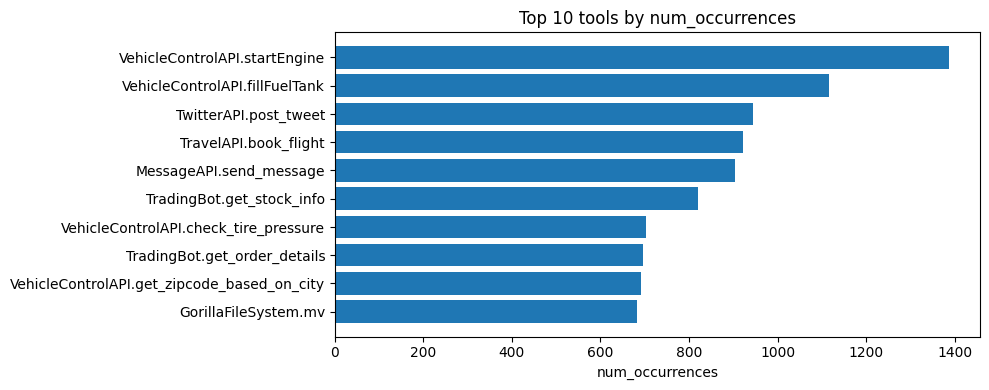

In [16]:
plt.figure(figsize=(10, 4))
plt.barh(top_called['tool_name'][::-1], top_called['num_occurrences'][::-1])
plt.title('Top 10 tools by num_occurrences')
plt.xlabel('num_occurrences')
plt.tight_layout()
plt.show()


## Top 10 tools by ground-truth usage (num_as_ground_truth)


In [17]:
top_gt = df.sort_values('num_as_ground_truth', ascending=False).head(10)
top_gt[['tool_name', 'num_as_ground_truth']]


,tool_name,num_as_ground_truth
263,VehicleControlAPI.startEngine,176
212,TradingBot.get_stock_info,172
225,TravelAPI.book_flight,164
257,VehicleControlAPI.get_zipcode_based_on_city,152
242,TwitterAPI.post_tweet,136
253,VehicleControlAPI.fillFuelTank,128
211,TradingBot.get_order_details,128
217,TradingBot.place_order,116
130,MessageAPI.send_message,112
230,TravelAPI.get_flight_cost,108


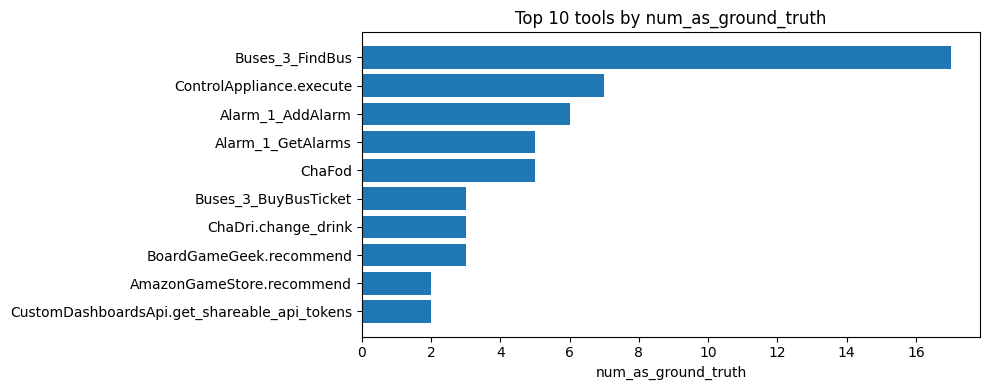

In [7]:
plt.figure(figsize=(10, 4))
plt.barh(top_gt['tool_name'][::-1], top_gt['num_as_ground_truth'][::-1])
plt.title('Top 10 tools by num_as_ground_truth')
plt.xlabel('num_as_ground_truth')
plt.tight_layout()
plt.show()


## Longest 5 augmented descriptions


In [8]:
longest_aug = df.sort_values('aug_desc_len_chars', ascending=False).head(5)
longest_aug[['tool_name', 'aug_desc_len_chars', 'aug_description']]


,tool_name,aug_desc_len_chars,aug_description
34,ClientAddress.set_address,1036,Use this tool to set or update the complete po...
15,B,1019,Use this tool to manage and execute a series o...
17,BankStatementOverView,1015,Use BankStatementOverView when the user wants ...
42,Crypto_tool.encrypt_decrypt,1015,Use this tool when the user wants to transform...
14,Attack,1014,Use this tool when the user explicitly request...


## Other stats


In [18]:
summary = {
    'num_tools': len(df),
    'unique_source_files': df['source_files'].explode().nunique(),
    'avg_aug_desc_len_chars': df['aug_desc_len_chars'].mean(),
    'median_aug_desc_len_chars': df['aug_desc_len_chars'].median(),
    'avg_orig_desc_len_chars': df['orig_desc_len_chars'].mean(),
    'median_orig_desc_len_chars': df['orig_desc_len_chars'].median(),
    'tools_with_multiple_orig_descs': (df['orig_descriptions'].apply(lambda x: isinstance(x, list) and len(x) > 1)).sum(),
    'tools_with_multiple_param_variants': (df['parameters_variants'].apply(lambda x: isinstance(x, list) and len(x) > 1)).sum(),
}
pd.DataFrame([summary]).T.rename(columns={0: 'value'})


,value
num_tools,1515.000000
unique_source_files,16.000000
avg_aug_desc_len_chars,911.198680
median_aug_desc_len_chars,912.000000
avg_orig_desc_len_chars,142.907591
median_orig_desc_len_chars,87.000000
tools_with_multiple_orig_descs,244.000000
tools_with_multiple_param_variants,428.000000


In [19]:
source_counts = df['source_files'].explode().value_counts().head(10)
source_counts


source_files
parallel_multiple          458
live_multiple              457
multiple                   443
simple_python              370
parallel                   186
simple_java                100
live_simple                 85
multi_turn_base             76
multi_turn_long_context     76
multi_turn_miss_func        76
Name: count, dtype: int64

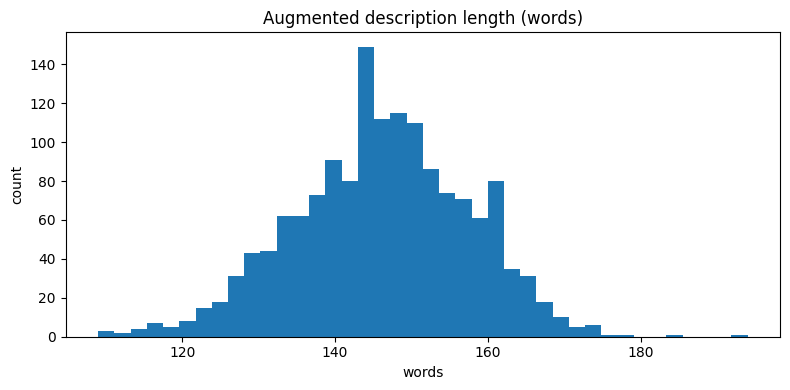

In [20]:
plt.figure(figsize=(8, 4))
plt.hist(df['aug_desc_len_words'], bins=40)
plt.title('Augmented description length (words)')
plt.xlabel('words')
plt.ylabel('count')
plt.tight_layout()
plt.show()


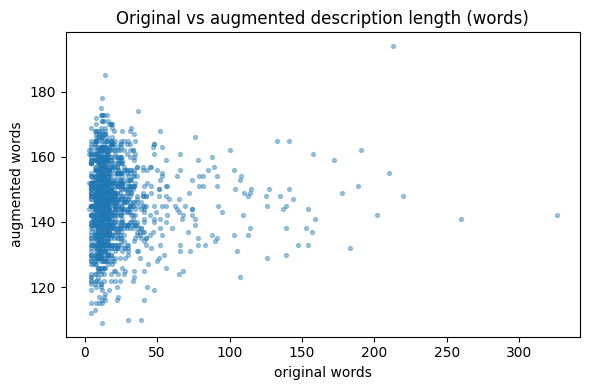

In [21]:
plt.figure(figsize=(6, 4))
plt.scatter(df['orig_desc_len_words'], df['aug_desc_len_words'], s=8, alpha=0.4)
plt.title('Original vs augmented description length (words)')
plt.xlabel('original words')
plt.ylabel('augmented words')
plt.tight_layout()
plt.show()
